# Réseau d'accès radio TP
Lucas Hocquette - Quentin Goulas

### Exercice 1 Capacité d'un système CDMA

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1
def sample_users(K,R):
    v = np.random.uniform(low=0,high=R**2,size=K)
    theta = np.random.uniform(low=0,high=2*np.pi,size=K)
    r = np.sqrt(v)
    x,y = r*np.cos(theta), r*np.sin(theta)
    return x,y

In [11]:
# 2
r = 1
W = 3.84*10**6
theta = 0.4
sigma2 = 10**(-104/10)*1e-3
P = 10**(40/10)*1e-3

def measure_achievement_ratio(K,R,gamma,n_avg=1):
    x,y = sample_users(K,r)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    history = np.zeros((n_avg,1))
    for i in range(n_avg):
        h = np.random.exponential(0.5,K)
        g = l*h
        p = P/K
        SINR = W/R*p*g/(theta*(K-1)*p*g+sigma2)
        history[i] = np.mean(SINR>=gamma)

    return history

print(f'{measure_achievement_ratio(20,32*1e3,10**(7/10))*100}%')
    

[[100.]]%


In [16]:
# 3 and 4

achievement_ratio = measure_achievement_ratio(20,32*1e3,10**(7/10),100)
print(f'delta = {np.mean(achievement_ratio)*100}%')

delta = 97.85000000000001%


In [26]:
# 5

K_values = np.array(range(1,100))
deltas = np.zeros(len(K_values))

for i,K in enumerate(K_values) :
    ach_rat = measure_achievement_ratio(K,32*1e3,10**(7/10),100)
    deltas[i] = np.mean(ach_rat)

print(deltas)
print(f'The maximum number of users on the network is {np.sum(deltas>=0.9)}')

[1.         1.         1.         0.985      0.996      0.99666667
 0.99428571 0.995      0.98777778 0.995      0.98636364 0.99083333
 0.99076923 0.99214286 0.98133333 0.991875   0.98176471 0.99611111
 0.97684211 0.972      0.9752381  0.975      0.97130435 0.96666667
 0.9648     0.95807692 0.96888889 0.97321429 0.95862069 0.95166667
 0.96806452 0.9746875  0.96545455 0.94058824 0.93685714 0.94194444
 0.9172973  0.94552632 0.89769231 0.924      0.91170732 0.93071429
 0.90581395 0.89068182 0.86644444 0.85630435 0.86404255 0.84833333
 0.86387755 0.86       0.85607843 0.74480769 0.72264151 0.73555556
 0.68509091 0.71285714 0.55385965 0.49982759 0.42186441 0.3205
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

### Exercice 2 Contrôle de puissance dans un système CDMA : Capacité et solution itérative

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

$$ 
F = \begin{pmatrix} 
        0, \frac{g_2}{R_1g_1}, \cdots, \frac{g_k}{R_1g_1} \\
        \frac{g_1}{R_2g_2}, 0, \ddots, \vdots \\
        \vdots, \ddots, \ddots, \vdots \\
        \frac{g_1}{R_kg_k}, \cdots, \cdots, 0
    \end{pmatrix}       
$$

In [ ]:
# 1.a

def sample_users(K,R):
    v = np.random.uniform(low=0,high=R**2,size=K)
    theta = np.random.uniform(low=0,high=2*np.pi,size=K)
    r = np.sqrt(v)
    x,y = r*np.cos(theta), r*np.sin(theta)
    return x,y

for K in [20,30,50,100]:
    # Example usage
    R = 1
    x, y = sample_users(K, R)

    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"User Locations (K={K})")
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.axis('equal')
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.scatter(0, 0, color='red', s=100)
    plt.show()

In [3]:
# 1.b
# K = np.array([20, 30, 50, 100],dtype=np.int32)
K = np.array(range(10,100,2), dtype=np.int32)
R = 1
r1,r2 = 15*1e3,32*1e3
W = 3.84*10**6
theta = 0.4
gamma1, gamma2  = 10**(5/10), 10**(7/10)
Rho = np.array([])

def generate_F(k,R,r1,r2,gamma1,gamma2,W,theta):
    x,y = sample_users(k,R)
    r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
    gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
    lamda = 0.5
    # h = np.random.exponential(1/lamda,k)
    h = np.ones(k)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    g = l*h
    G1,G2 = np.meshgrid(gamma*r*g,g)
    F = (theta/W)*G1 / G2
    F[np.eye(k,dtype=np.bool)] = 0
    return F, r, gamma, g

for k in K:
    F,_,_,_ = generate_F(k,R,r1,r2,gamma1,gamma2,W,theta)
    rho = np.max(np.abs(np.linalg.eigvals(F)))
    Rho = np.append(Rho,rho)

Kmax = np.max(K[Rho<1])
print(Kmax)

92


C:\Users\lucas\AppData\Local\Temp/ipykernel_16220/1958558858.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  F[np.eye(k,dtype=np.bool)] = 0


In [4]:

#1.c
k = Kmax

x,y = sample_users(k,R)
r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
lamda = 0.5
h = np.ones(k)
d = np.sqrt(x**2+y**2)
L = -128.1 - 37.6*np.log10(d)
l = 10**(L/10)
g = l*h
G1,G2 = np.meshgrid(gamma*r*g,g)
F = (theta/W)*G1 / G2
F[np.eye(k,dtype=np.bool)] = 0

sigma2 = 10**(-104/10)/1000
b = sigma2*(1/(3.84*10**6))*r*gamma/g
P =  np.linalg.inv(np.eye(k) - F)@b

print(10*np.log10(P*1000)) # display the power allocation in dBm

def SINR(W,R,P,G,theta,sigma2):
    alpha = W/R
    pg = P*G
    pg1,_ = np.meshgrid(pg,pg)
    pg1[np.eye(len(pg),dtype=np.bool)] = 0
    sm = np.sum(pg1,axis=1)
    return alpha*pg/(theta*sm+sigma2)

[23.72671128 22.17972659 23.96529383 26.41476634 14.90839377 19.26367885
  8.4904753  23.58839292 26.38694674 22.98151924 16.89555007 20.91384818
 14.53209069 21.31748286 24.58670934 22.30215709 21.69801414  2.6164473
 13.67429627 25.71952852 21.96914512 20.42027917 16.99243314 24.07298167
 13.21212976 23.04548363 25.87265149 22.41142693 24.93438417 14.8641698
 21.9995389  20.34633081 14.7205677  23.46982552 15.83800461 25.30768652
 13.06598449 11.92114415 24.69827186 24.26407669 23.98367748  0.31388531
 26.43205469 22.64207253 18.57960386 26.35417062  4.08113337 11.74429825
 26.610251   24.94712961 25.13858156 19.55048966 20.65672127 20.36693469
 19.63501095  3.72211999  9.55799033 16.89068434 20.28990913  7.59754544
 26.13842398 17.21351041 24.65407591 22.79899542 14.74889605 11.79568654
 12.11371198 24.24963713 25.25670994  3.75427963 22.58220355 20.64318649
  5.90334143 -0.43548274 24.67430599 16.0654456   1.84578892 25.2287501
 24.32046685 24.4841178  17.48377776 25.86987596 26.52

k=10, num_iteration=3
k=12, num_iteration=4
k=14, num_iteration=1
k=16, num_iteration=4
k=18, num_iteration=1
k=20, num_iteration=4
k=22, num_iteration=4
k=24, num_iteration=4
k=26, num_iteration=4
k=28, num_iteration=5
k=30, num_iteration=6
k=32, num_iteration=6
k=34, num_iteration=5
k=36, num_iteration=8
k=38, num_iteration=5
k=40, num_iteration=16
k=42, num_iteration=13
k=44, num_iteration=7
k=46, num_iteration=7
k=48, num_iteration=7
k=50, num_iteration=9
k=52, num_iteration=10
k=54, num_iteration=8
k=56, num_iteration=12
k=58, num_iteration=18
k=60, num_iteration=13
k=62, num_iteration=14
k=64, num_iteration=10
k=66, num_iteration=7
k=68, num_iteration=15
k=70, num_iteration=19
k=72, num_iteration=30
k=74, num_iteration=16
k=76, num_iteration=27
k=78, num_iteration=29
k=80, num_iteration=27
k=82, num_iteration=23
k=84, num_iteration=57
k=86, num_iteration=28
k=88, num_iteration=23
k=90, num_iteration=52


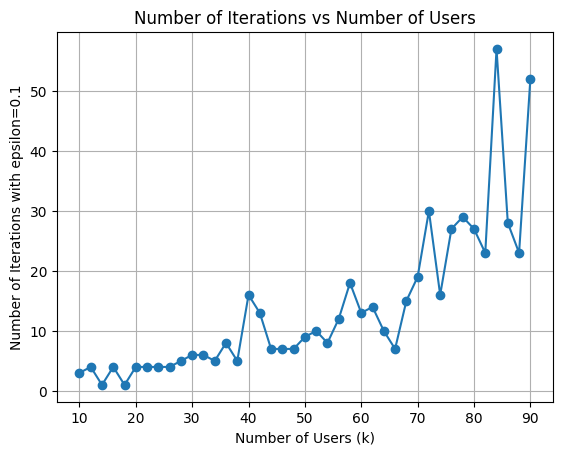

In [5]:
#1.d
K_list = np.array(range(10,Kmax,2), dtype=np.uint32)
epsilon = 0.1
iteration_list = np.zeros(len(K_list))

for idx in range(len(K_list)):
    k = K_list[idx]
    p = np.ones(k)
    new_p = np.ones(k)*0.1
    num_iteration = 0
    _, r, gamma, g = generate_F(k,R,r1,r2,gamma1,gamma2,W,theta)
    while not np.all(np.abs(p - new_p) < epsilon):
        p = new_p
        pg = p*g
        pg1,_ = np.meshgrid(pg,pg)
        pg1[np.eye(len(pg),dtype=np.bool)] = 0
        sm = np.sum(pg1,axis=1)
        new_p = (r*gamma*(theta*sm + sigma2))/(W*g)
        num_iteration += 1
    iteration_list[idx] = num_iteration
    print(f"k={k}, num_iteration={num_iteration}")

plt.plot(K_list, iteration_list, marker='o')
plt.xlabel('Number of Users (k)')
plt.ylabel(f'Number of Iterations with epsilon={epsilon}')
plt.title('Number of Iterations vs Number of Users')
plt.grid(True)
plt.show()
    

In [37]:
# 1.e

def iterativeE(gamma,beta,tol,seed):
    p=seed.copy()
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while np.sum(abs(p-p_old))>=tol:
        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p = (1-beta)*p + beta*gamma/sinr*p
        iter +=1
    return p, iter

Beta = [0.1,0.3,0.5,0.8,1]
Niter = np.zeros_like(Beta)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for b in range(len(Beta)):
    p,iter = iterativeE(gamma,Beta[b],1e-3,seed)
    Niter[b] = iter

print(Niter)

[4635. 1744. 1101.  719.  586.]


In [7]:
# 1.f

def iterativeF(gamma,alpha,tol,seed,maxIter):
    p = seed.copy()
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while (np.sum(abs(p-p_old))>=tol) & (iter<maxIter):
        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p[sinr<gamma] = alpha*p_old[sinr<gamma]
        p[sinr>gamma] = p_old[sinr>gamma]/alpha
        iter +=1
    return p, iter

Alpha = 10**(np.linspace(0.25,1.5,7)/10)
Niter = np.zeros_like(Alpha)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for a in range(len(Alpha)):
    p,iter = iterativeF(gamma,Alpha[a],1e-3,seed,5e3)
    Niter[a] = iter

print(Niter)

[1. 1. 1. 1. 1. 1. 1.]


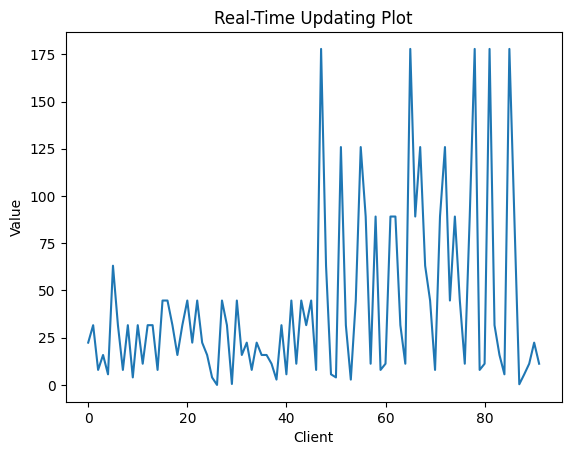

0.0031946780169746104
[99. 54. 37. 29. 23. 19. 17.]


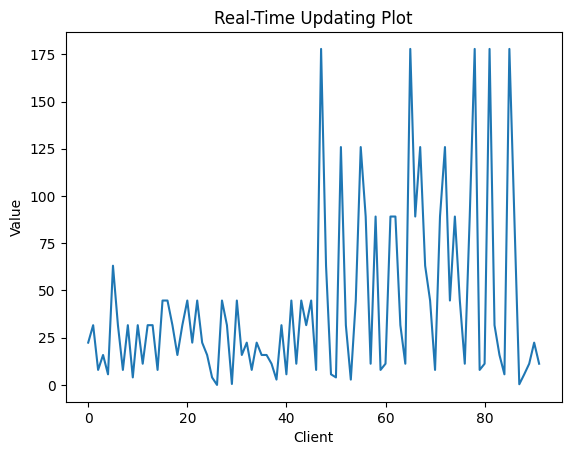

In [12]:
# 1.g

# plt.ion()  # Turn on interactive mode

# Create a figure and axis for the plot
fig, ax = plt.subplots()
ax.set_title('Real-Time Updating Plot')
ax.set_xlabel('Client')
ax.set_ylabel('Value')

# Initialize an empty list for the data
p_plot = []

# Plot the initial empty data
line, = ax.plot(p_plot)

# Display the plot
display(fig)

def update_plot(p):
    clear_output(wait=True)
    line.set_ydata(p)
    line.set_xdata(range(len(p)))
    ax.relim()
    ax.autoscale_view()
    display(fig)

def iterativeG(gamma,alpha,tol,maxIter):
    p = np.ones(Kmax)
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while (np.sum(abs(p-p_old))/Kmax>=tol) & (iter<maxIter):
        p_old = np.copy(p)
        sinr = SINR(W,r,p,g,theta,sigma2)
        p[sinr > alpha*gamma*p_old] = p_old[sinr > alpha*gamma*p_old]/alpha
        p[sinr < gamma*alpha**(-1)] = p_old[sinr < gamma*alpha**(-1)]*alpha
        iter += 1
        if iter % 1 == 0:
            update_plot(p)
            print(np.sum(abs(p-p_old))/Kmax)
    return p, iter

Alpha = 10**(np.linspace(0.25,1.5,7)/10)
#Alpha = [10**(0.25/10), 10**(0.25/10), 10**(0.25/10)]
Niter = np.zeros_like(Alpha)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)
epsilon = 5e-3

for a in range(len(Alpha)):
    p_alpha,iter = iterativeG(gamma,Alpha[a],epsilon,5e3)
    Niter[a] = iter

print(Niter)

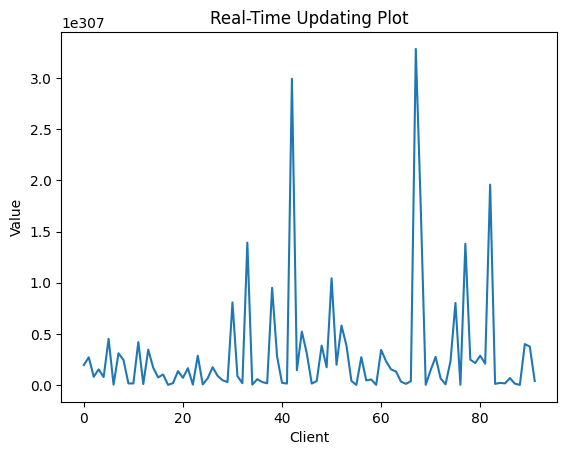

[1470.  704.  544.  437.  398.]


C:\Users\goula\AppData\Local\Temp\ipykernel_26896\4155344215.py:30: RuntimeWarning: invalid value encountered in multiply
  p = (1-beta)*p + beta*gamma/sinr*p


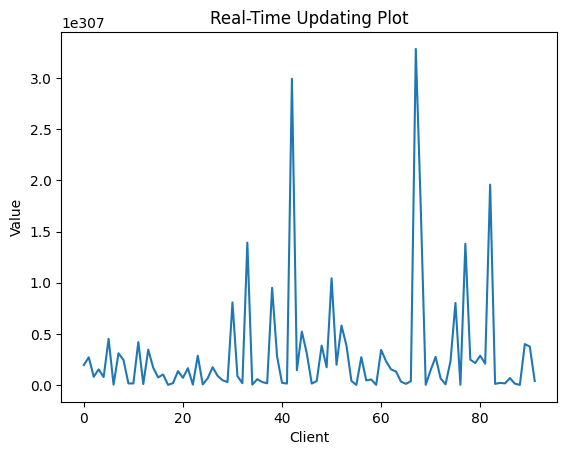

In [56]:
# 2.a


def generate_F2(k,R,r1,r2,gamma1,gamma2,W,theta):
    x,y = sample_users(k,R)
    r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
    gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    return r, gamma

def iterativeE(gamma,beta,tol,seed,k):
    p=seed
    p_old = np.inf*np.ones_like(p)
    iter = 0
    lamda = 0.5
    while np.sum(abs(p-p_old))>=tol:

        # new h at each iteration
        h = np.random.exponential(1/lamda,k)
        # h = np.ones(k)
        g = l*h
        G1,G2 = np.meshgrid(gamma*r*g,g)
        F = (theta/W)*G1 / G2
        F[np.eye(k,dtype=np.bool)] = 0

        p_old = p
        sinr = SINR(W,r,p,g,theta,sigma2)
        p = (1-beta)*p + beta*gamma/sinr*p
        iter +=1
        if iter % 5 == 0:
            update_plot(p)
        
    return p, iter

fig, ax = plt.subplots()
ax.set_title('Real-Time Updating Plot')
ax.set_xlabel('Client')
ax.set_ylabel('Value')
p_plot = []
line, = ax.plot(p_plot)
display(fig)


Beta = [0.1,0.3,0.5,0.8,1]
Niter = np.zeros_like(Beta)
r, gamma = generate_F2(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for b in range(len(Beta)):
    p,iter = iterativeE(gamma,Beta[b],1e-3,seed,Kmax)
    Niter[b] = iter

print(Niter)

### Exercice 3 : Comparison between CDMA and TDMA systems

In [27]:
# 1

r = 1
W = 3.84*10**6
theta = 0.4
sigma2 = 10**(-104/10)*1e-3
P = 10**(40/10)*1e-3

def measure_achievement_ratio(K,R,gamma,n_avg=1):
    x,y = sample_users(K,r)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    history = np.zeros((n_avg,1))
    for i in range(n_avg):
        h = np.random.exponential(0.5,K)
        g = l*h
        p = P/K
        SINR = W/R*p*g/(theta*(K-1)*p*g+sigma2)
        history[i] = np.mean(SINR>=gamma)

    return history

K_values = np.array(range(1,100))
deltas = np.zeros(len(K_values))

for i,K in enumerate(K_values) :
    ach_rat = measure_achievement_ratio(K,240*1e3,10**(10/10),100)
    deltas[i] = np.mean(ach_rat)

# print(deltas)
print(f'The maximum number of users on the network is {np.sum(deltas>=0.9)}')

[0.98       0.96       0.92666667 0.8475     0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
The maximum number of